In [1]:
from model import simple_unet_model   
from keras.utils.np_utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
tf.to_int=lambda x: tf.cast(x, tf.int32)
from tensorflow.keras.metrics import AUC

In [3]:
cd

C:\Users\hp


In [4]:
image_directory = 'Downloads/kaggle_TGS/train/images/'
mask_directory = 'Downloads/kaggle_TGS/train/masks/'

In [5]:
SIZE = 128  #As Un-net accepts image dimensions in the power of 2. All 101*101 pixel input images are resized to 128*128
image_dataset = []  
mask_dataset = []   #using list format to handle data, can also use pandas.  

In [6]:
images = os.listdir(image_directory)

In [7]:
images[0]

'000e218f21.png'

In [8]:
masks = os.listdir(mask_directory)

In [9]:
len(images)

4000

In [10]:
len(masks)

4000

In [11]:
masks[0]

'000e218f21.png'

In [12]:
#Creating image dataset

In [13]:
for i, image_name in enumerate(images):   
    image = cv2.imread(image_directory+image_name, 0)  #here image is an array
    image = Image.fromarray(image)                     #here image becomes in actual image form
    image = image.resize((SIZE, SIZE))                 #resize based on pixel value
    image_dataset.append(np.array(image))              #covert back to array and then store in dataset

In [14]:
#Creating mask dataset

In [15]:
for i, image_name in enumerate(masks):
    image = cv2.imread(mask_directory+image_name, 0)
    image = Image.fromarray(image)
#     plt.imshow(image, cmap='gray')
#     plt.show()
    image = image.resize((SIZE, SIZE))
    mask_dataset.append(np.array(image))
#     break

In [16]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)

#Inspite of normalizing masks, just rescale to 0 to 1 as it only contains salt and no salt pixels
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [17]:
len(image_dataset)

4000

In [18]:
len(mask_dataset)

4000

In [19]:
image_dataset[0]

array([[[0.08164274],
        [0.08166838],
        [0.081683  ],
        ...,
        [0.06022023],
        [0.06284424],
        [0.06482393]],

       [[0.08164274],
        [0.08166838],
        [0.081683  ],
        ...,
        [0.05591878],
        [0.0585314 ],
        [0.06111971]],

       [[0.0828892 ],
        [0.08291522],
        [0.0835536 ],
        ...,
        [0.05100285],
        [0.05360244],
        [0.05556337]],

       ...,

       [[0.08849824],
        [0.08914945],
        [0.08916541],
        ...,
        [0.06452167],
        [0.06346036],
        [0.06235445]],

       [[0.09036792],
        [0.08790261],
        [0.08604774],
        ...,
        [0.07681152],
        [0.07639888],
        [0.0759366 ]],

       [[0.09099115],
        [0.08727918],
        [0.08417714],
        ...,
        [0.08541441],
        [0.0862568 ],
        [0.08643191]]])

In [20]:
mask_dataset[0]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

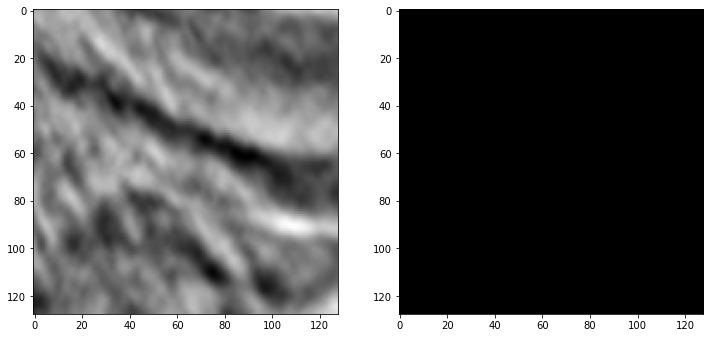

In [22]:
#Sanity check to make sure each mask correspond to its image 
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
# plt.imshow(np.reshape(X_train[image_number], (101, 101)), cmap='gray')
plt.imshow(X_train[image_number], cmap='gray')
plt.subplot(122)
# plt.imshow(np.reshape(y_train[image_number], (101, 101)), cmap='gray')
plt.imshow(y_train[image_number], cmap='gray')
plt.show()

In [23]:
image_dataset.shape

(4000, 128, 128, 1)

In [24]:
mask_dataset.shape

(4000, 128, 128, 1)

In [25]:
im_height  = image_dataset.shape[1]
im_width  = image_dataset.shape[2]
im_chan = image_dataset.shape[3]

In [26]:
#using U-net as it is the best model for segmentation of images in comparison to others

In [27]:
def get_model():
    return simple_unet_model(im_height, im_width, im_chan)

model = get_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 8)    0           ['conv2d_1[0][0]']           

In [28]:
#results are calculated for both train and validation dataset, to identify any case of over/under-fitting
#model is fitted using earlystopper and checkpointer callbacks to stop and save the model as per conditions

In [29]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=12, epochs=10, callbacks=[earlystopper, checkpointer])

Epoch 1/10
270/270 [==============================] - ETA: 0s - loss: 0.5774 - accuracy: 0.7455 - auc: 0.4838
Epoch 1: val_loss improved from inf to 0.54046, saving model to model-tgs-salt
INFO:tensorflow:Assets written to: model-tgs-salt\assets
270/270 [==============================] - 178s 645ms/step - loss: 0.5774 - accuracy: 0.7455 - auc: 0.4838 - val_loss: 0.5405 - val_accuracy: 0.7744 - val_auc: 0.5090
Epoch 2/10
270/270 [==============================] - ETA: 0s - loss: 0.5595 - accuracy: 0.7455 - auc: 0.5498
Epoch 2: val_loss improved from 0.54046 to 0.52480, saving model to model-tgs-salt
INFO:tensorflow:Assets written to: model-tgs-salt\assets
270/270 [==============================] - 163s 603ms/step - loss: 0.5595 - accuracy: 0.7455 - auc: 0.5498 - val_loss: 0.5248 - val_accuracy: 0.7744 - val_auc: 0.6109
Epoch 3/10
270/270 [==============================] - ETA: 0s - loss: 0.5280 - accuracy: 0.7456 - auc: 0.6769
Epoch 3: val_loss improved from 0.52480 to 0.40051, saving m

# Model Performance

In [ ]:
#to get model back without re-training it

In [ ]:
model = get_model()
model.load_weights('model-tgs-salt') 

In [ ]:
#result of model: can't depend just on accuracy for Segmentation Purpose, as high accuracy can still be achieved 
#when the whole background is predicted nicely while leaving out specific areas of salt
#Hence, will also calculated Iou score along with comparison to real masks

In [30]:
print(model.evaluate(X_test, y_test))

13/13 [==============================] - 5s 340ms/step - loss: 0.2587 - accuracy: 0.8986 - auc: 0.9357
[0.25868627429008484, 0.8986119031906128, 0.9356940388679504]


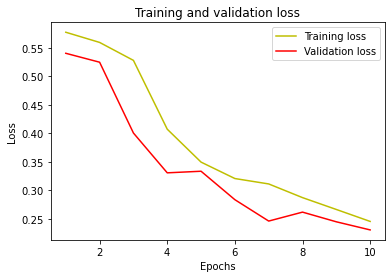

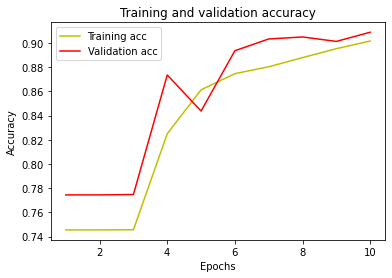

In [31]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Most Desired IOu score 70-80%+
#Achieved Iou score is sufficient to proceed with

In [32]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.6717130062064666


In [ ]:
#Comparison of predicted mask with real test mask

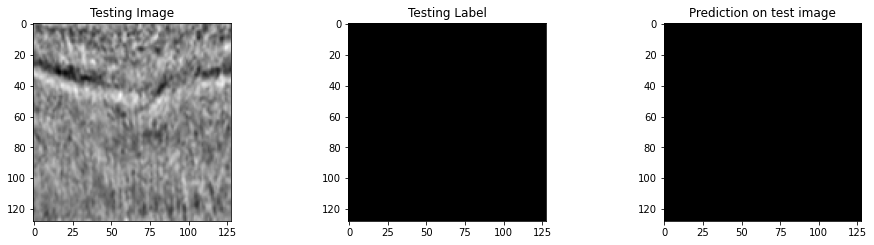

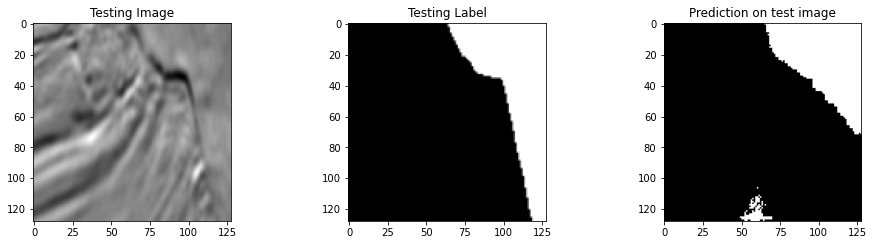

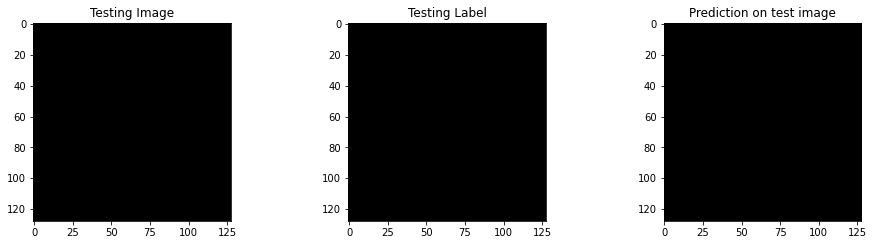

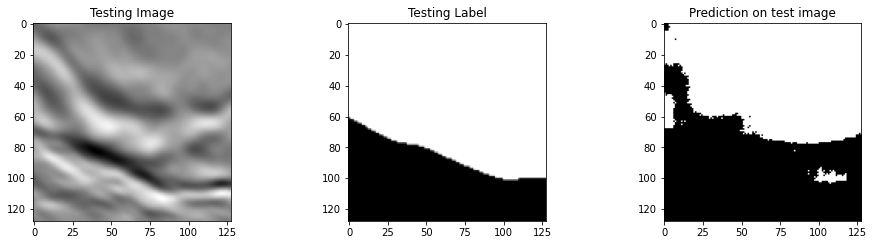

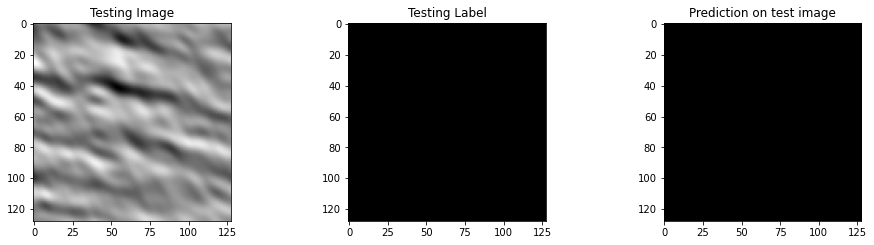

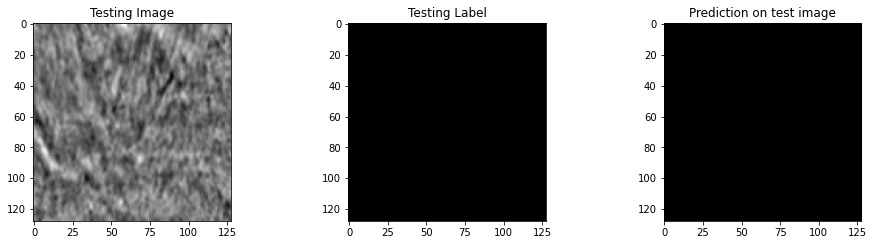

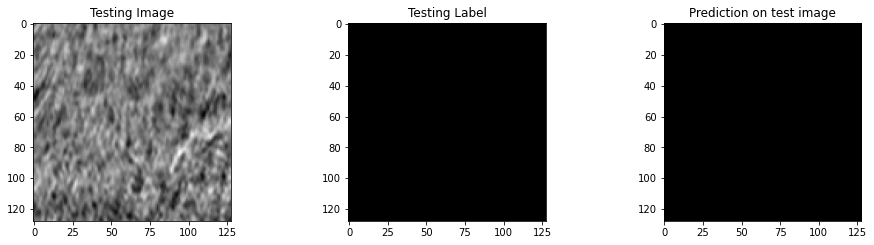

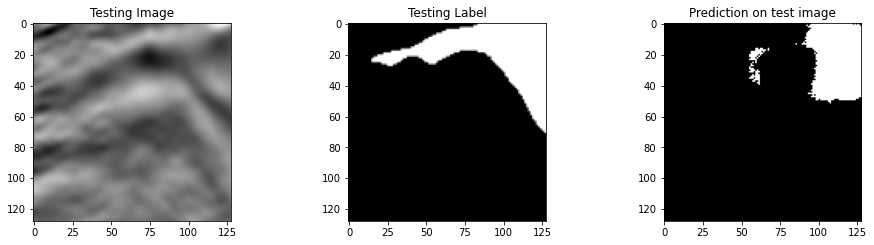

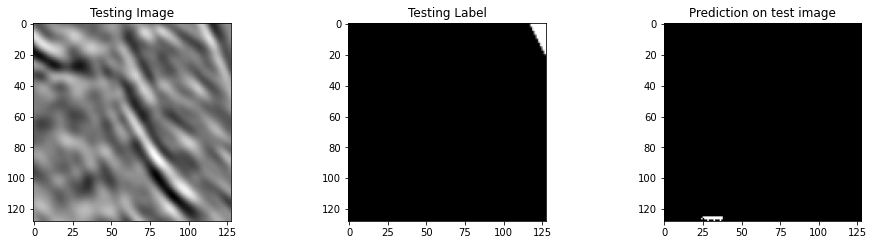

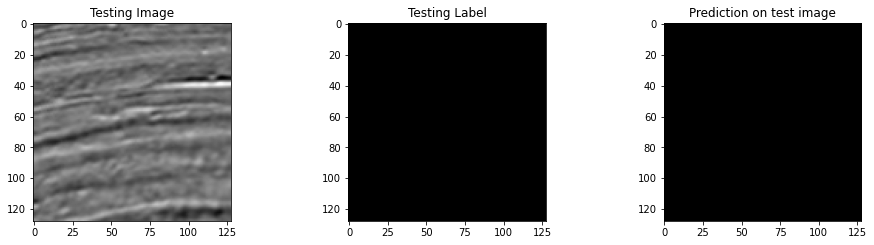

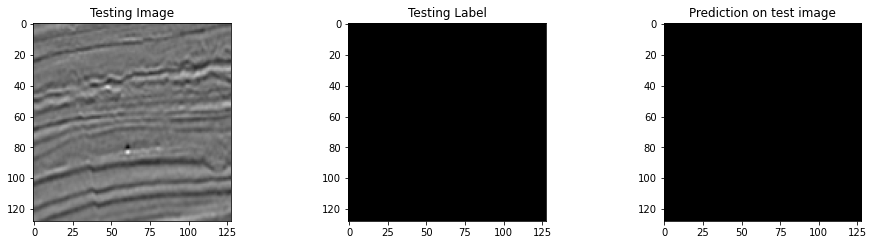

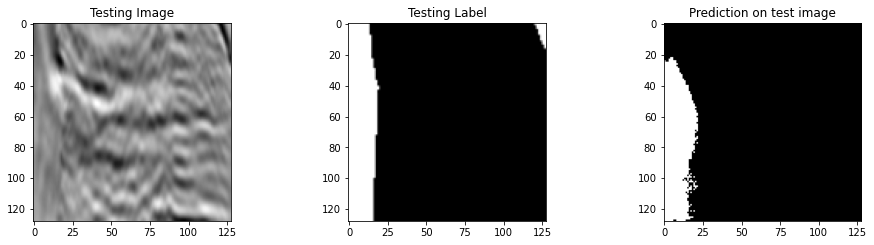

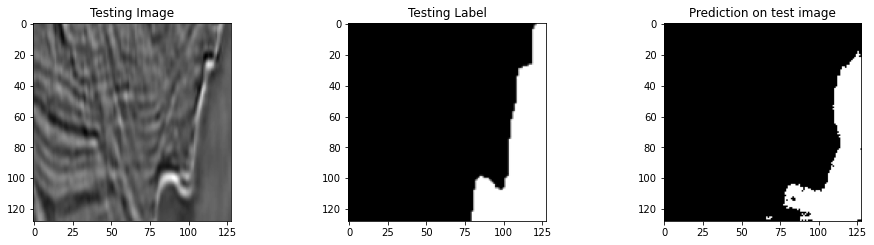

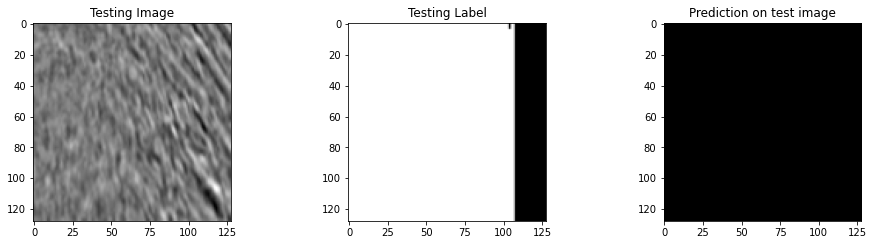

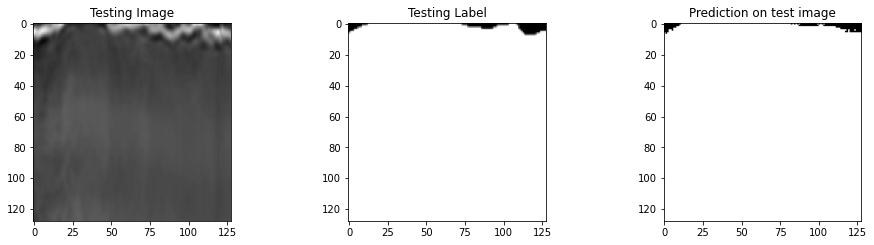

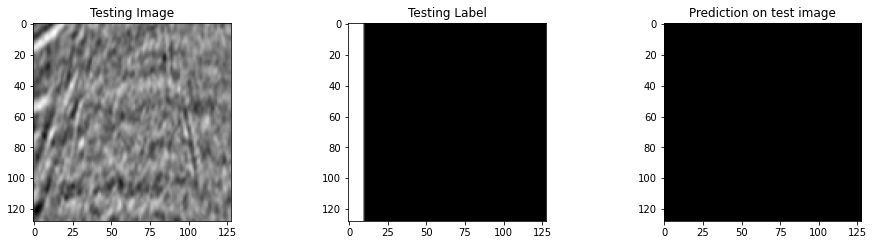

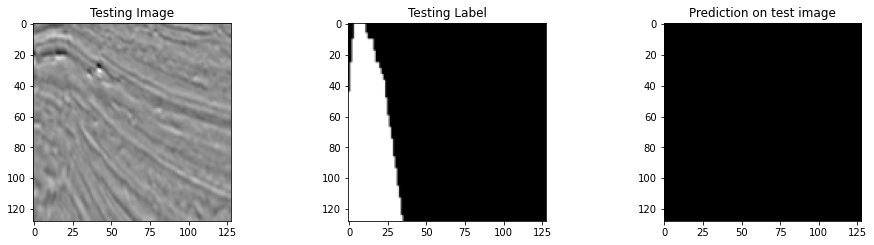

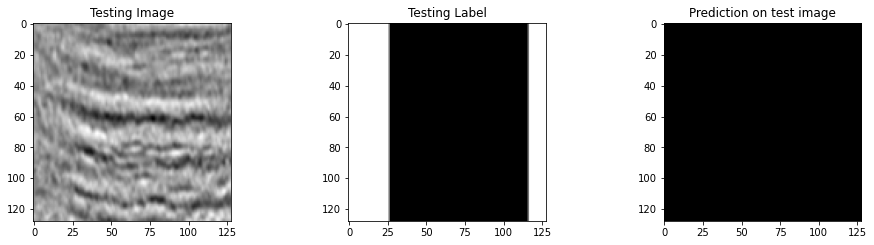

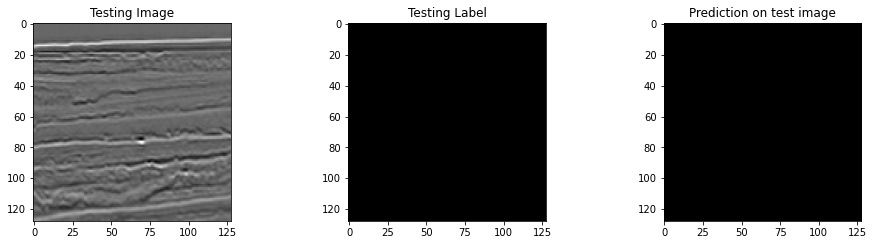

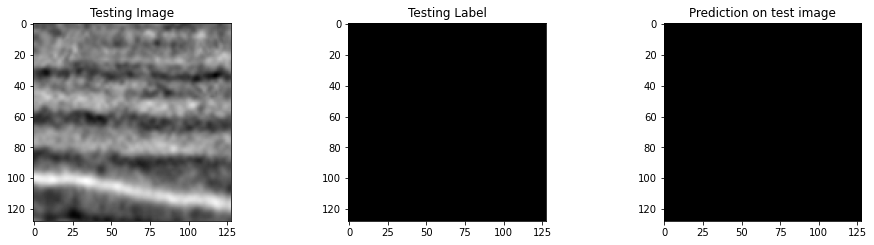

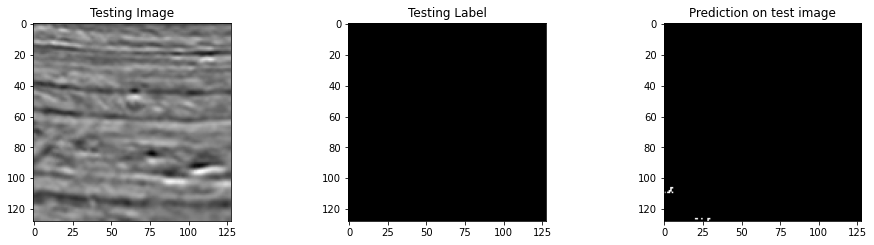

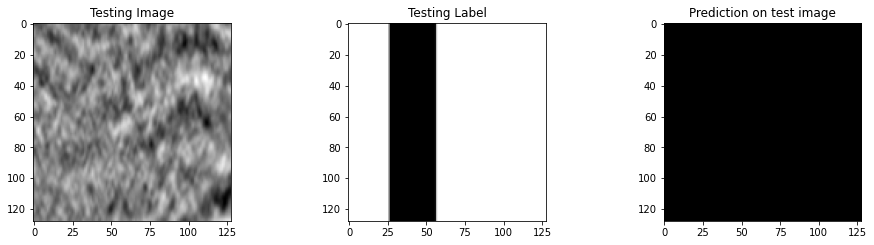

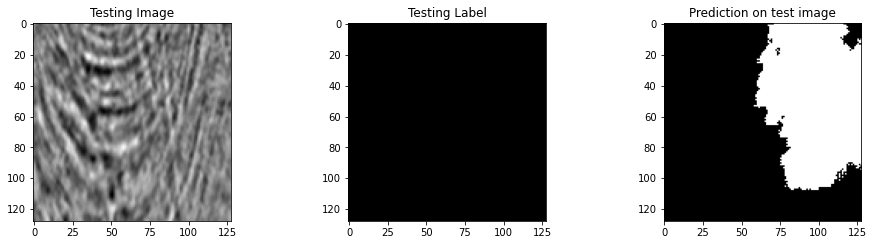

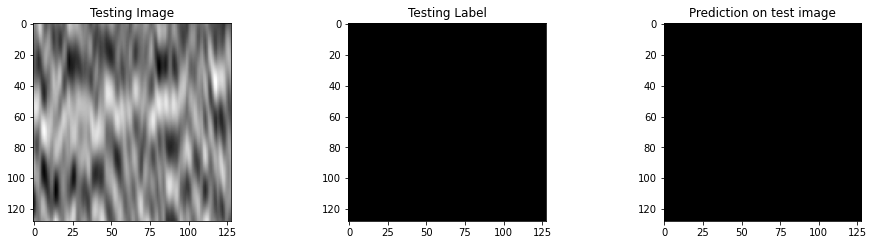

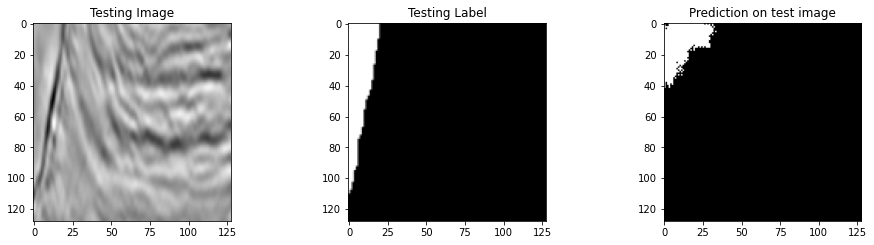

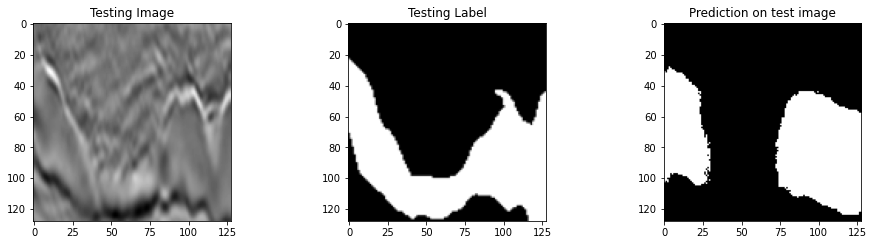

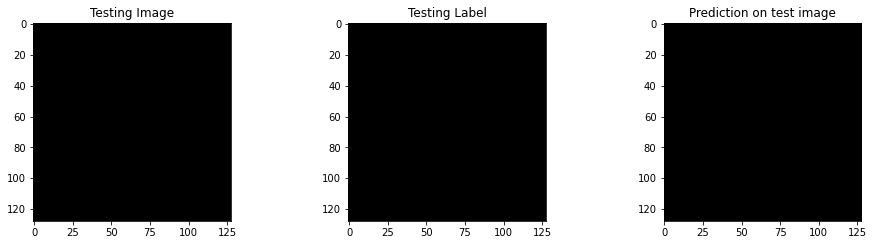

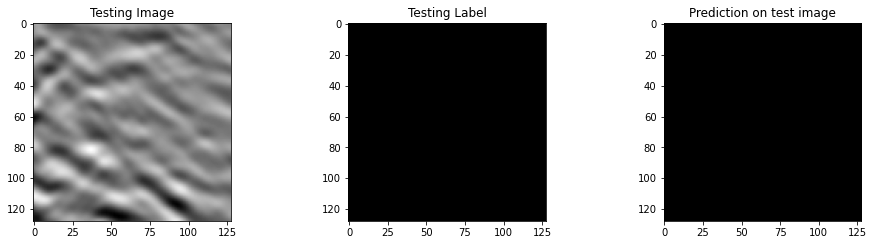

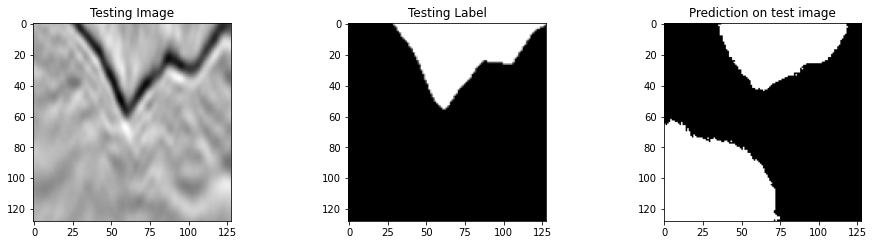

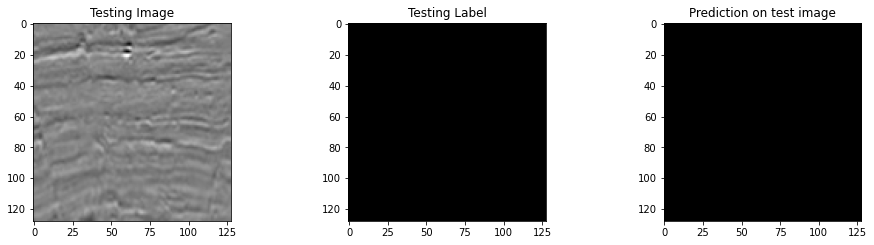

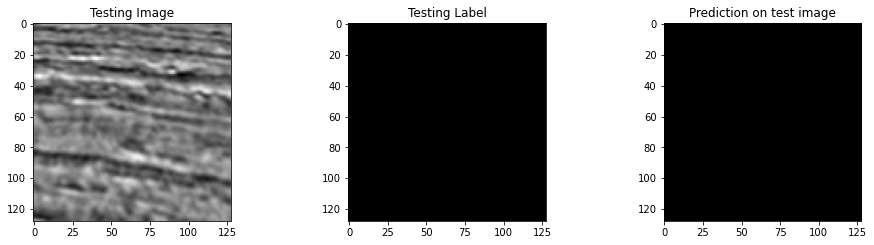

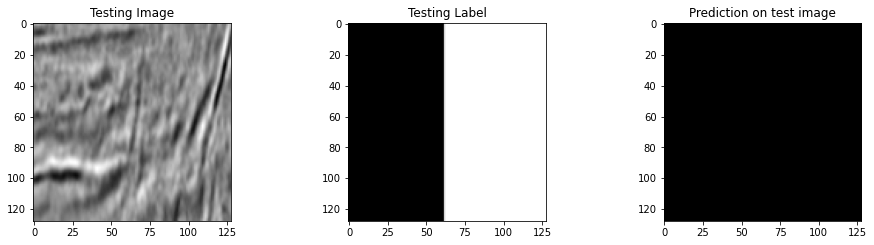

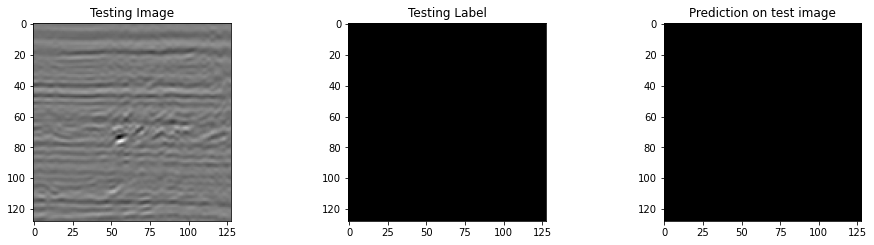

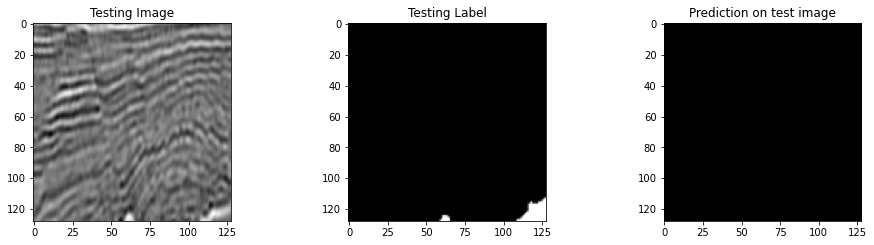

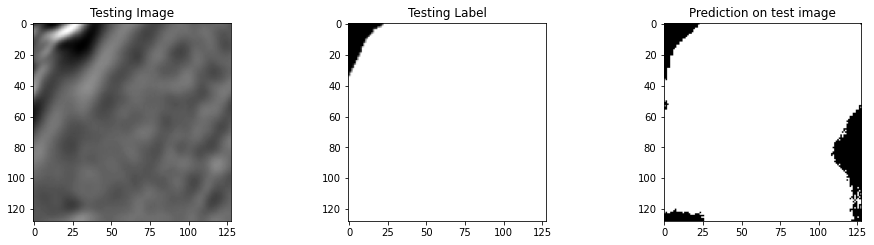

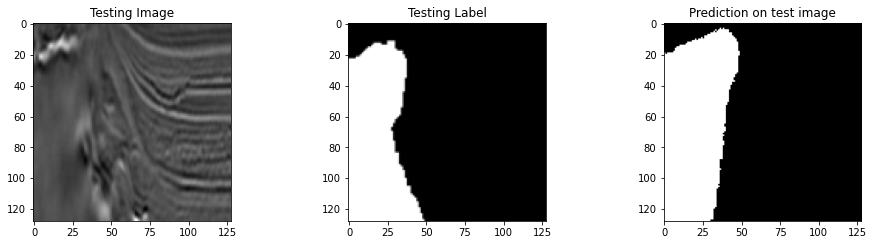

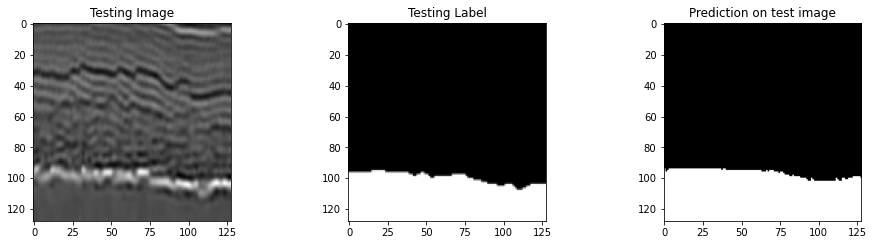

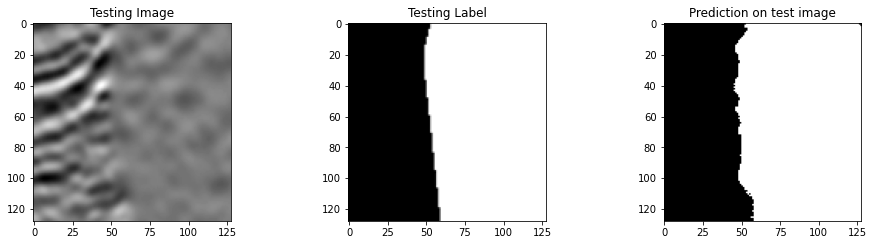

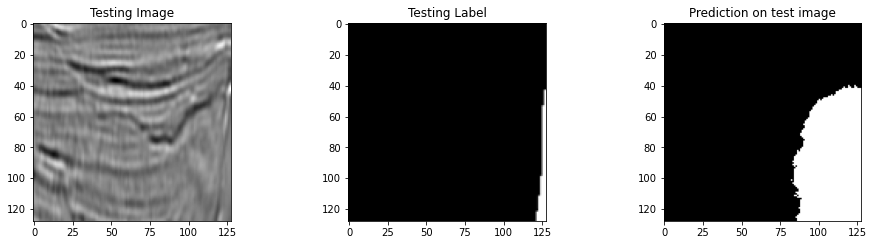

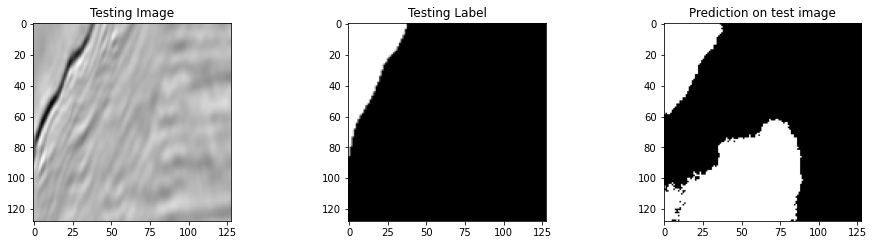

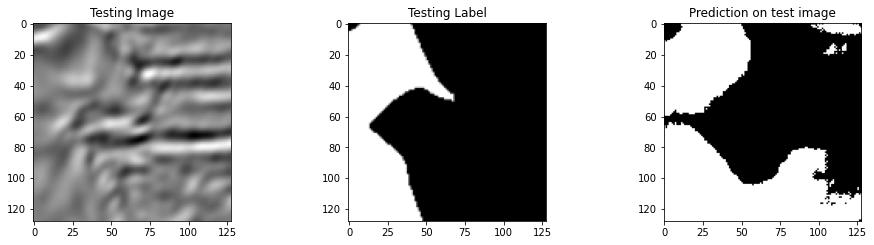

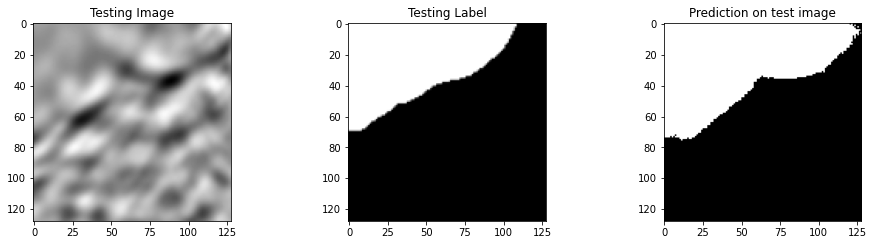

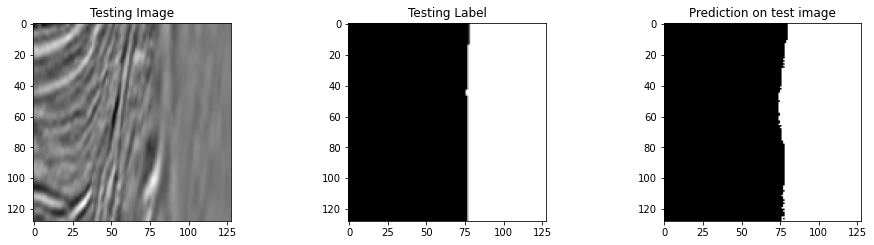

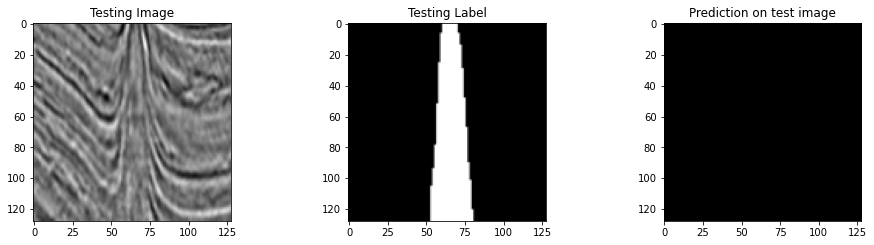

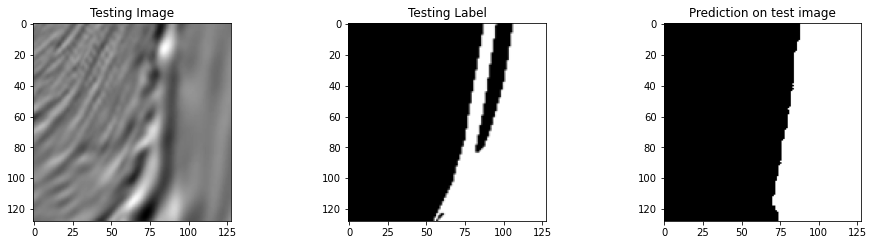

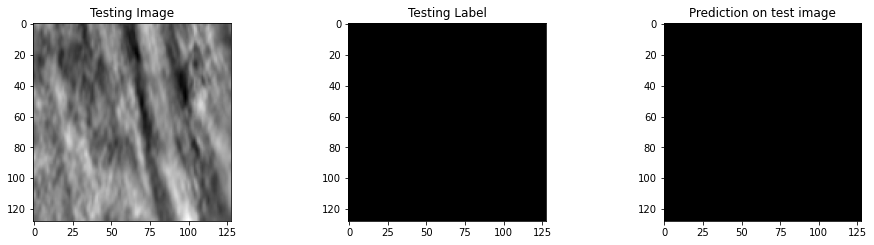

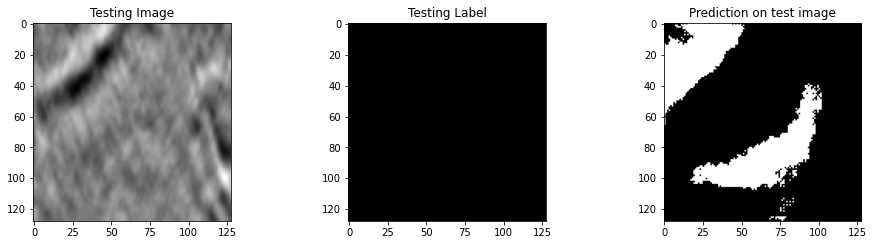

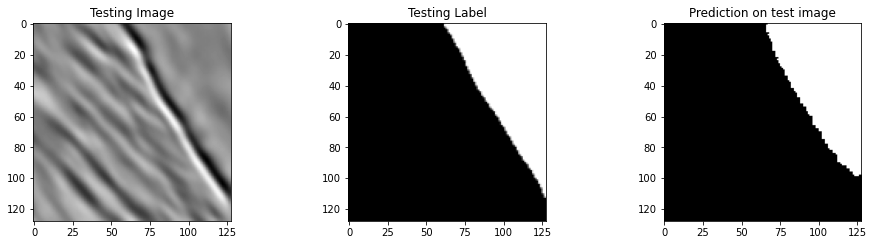

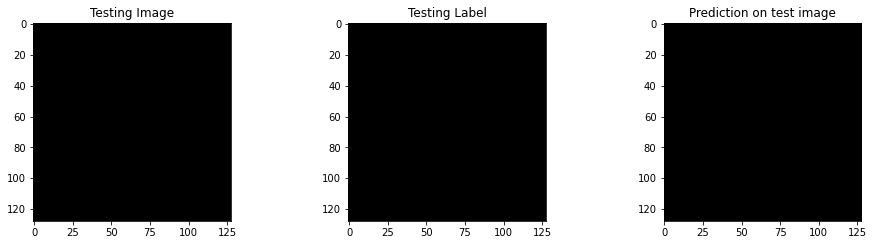

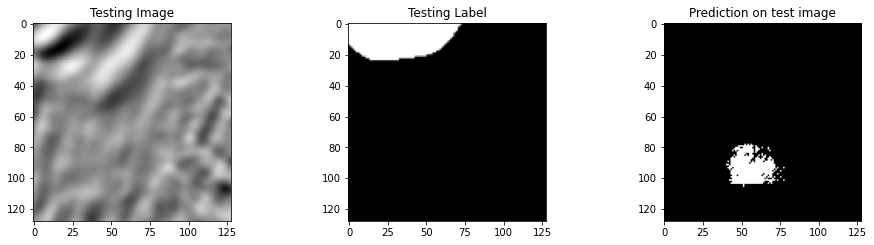

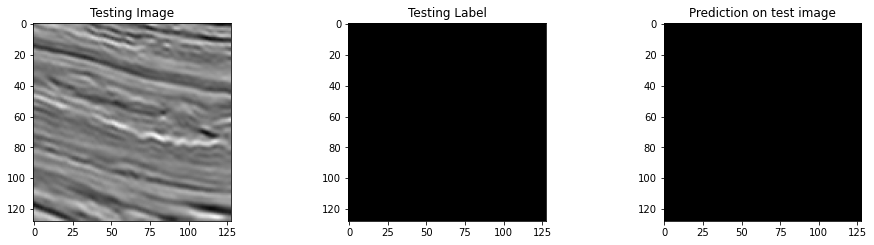

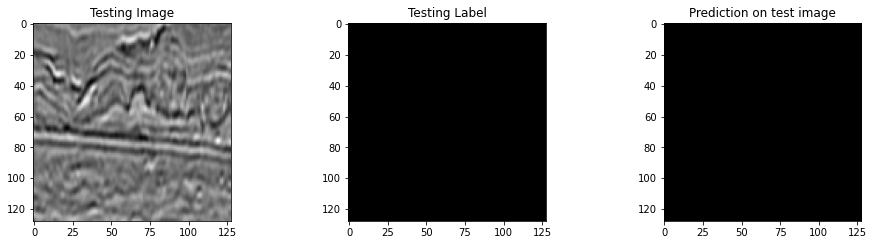

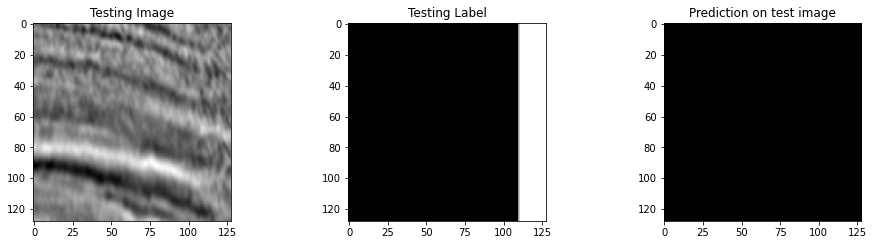

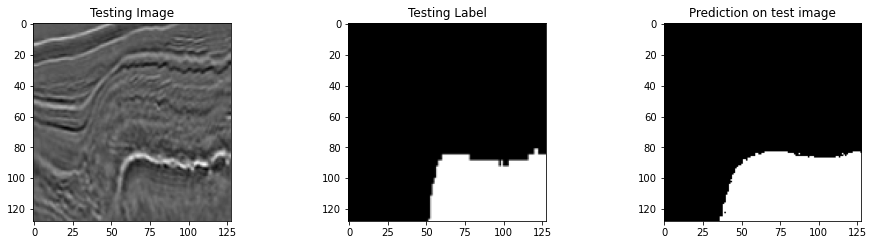

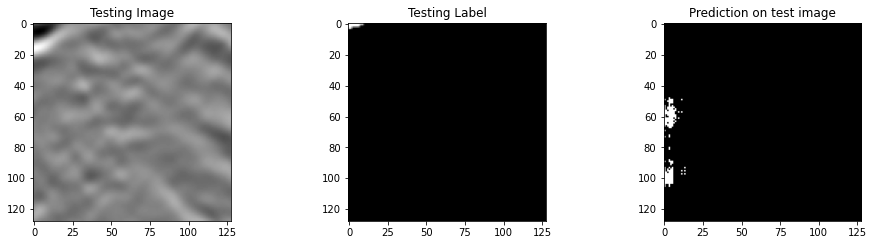

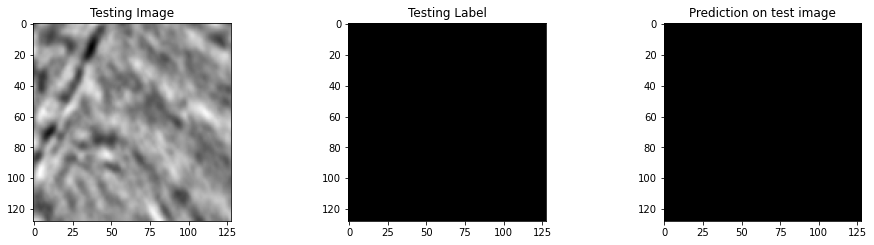

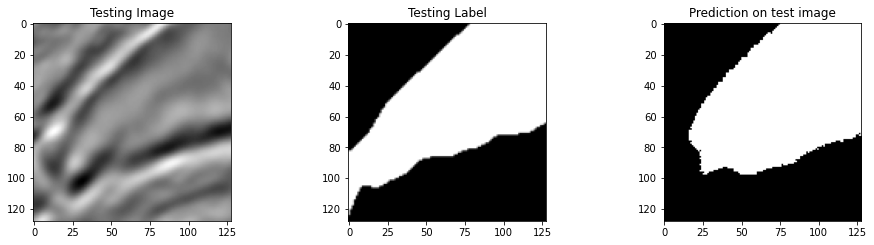

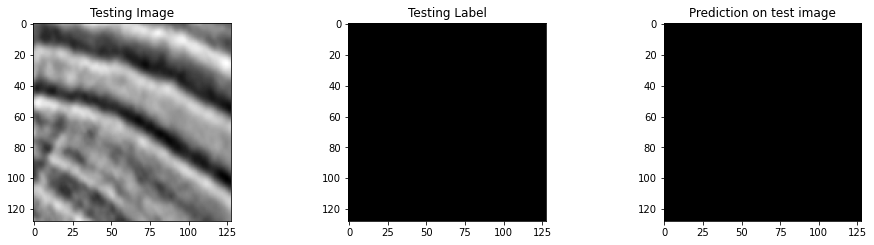

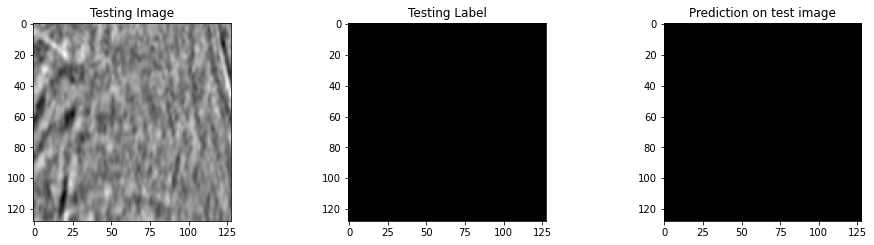

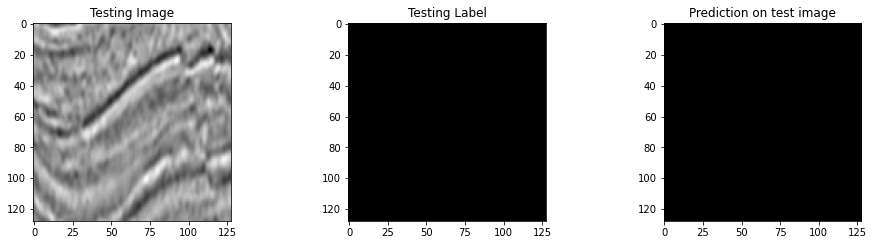

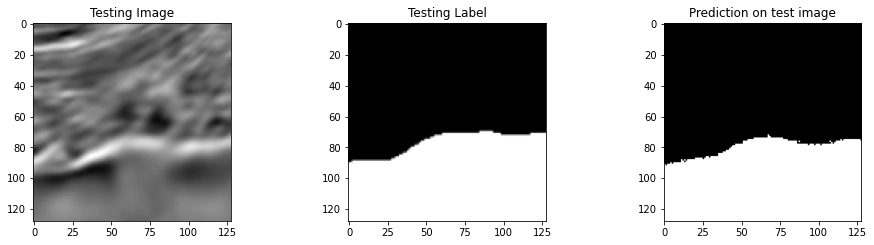

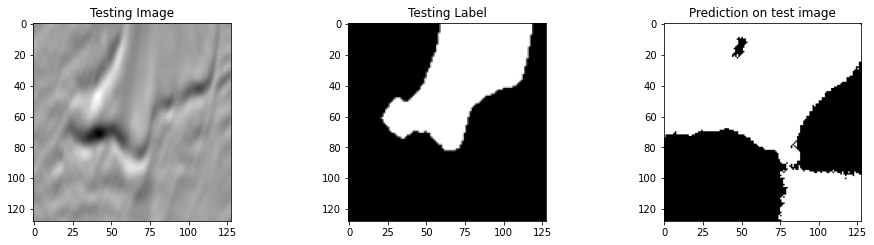

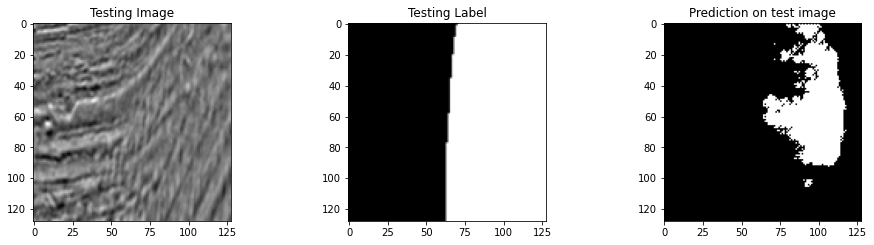

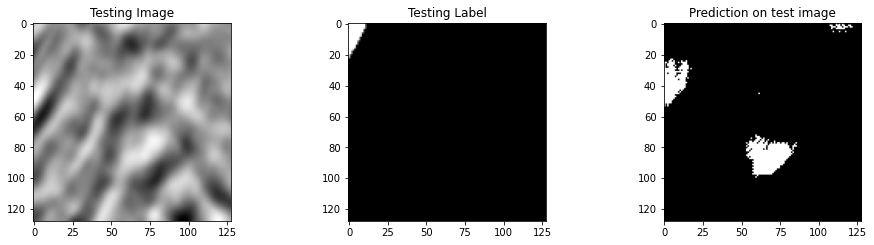

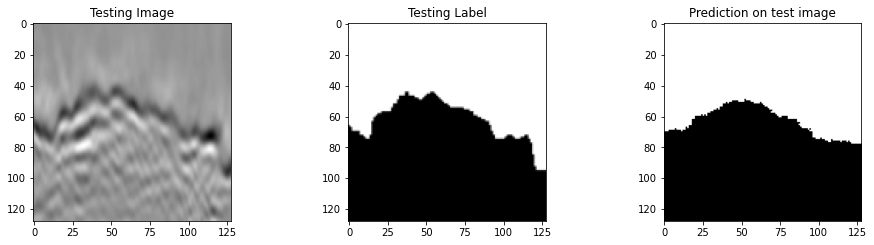

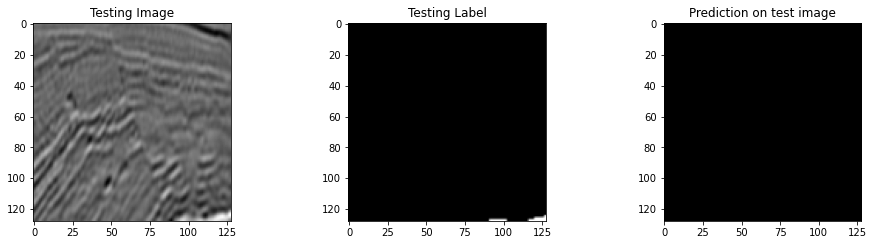

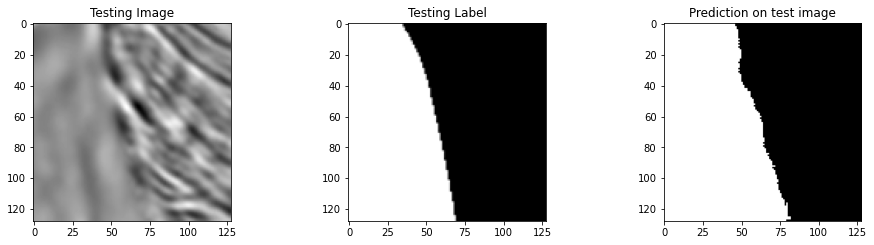

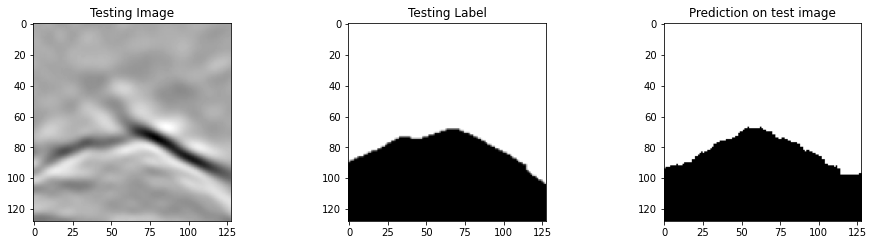

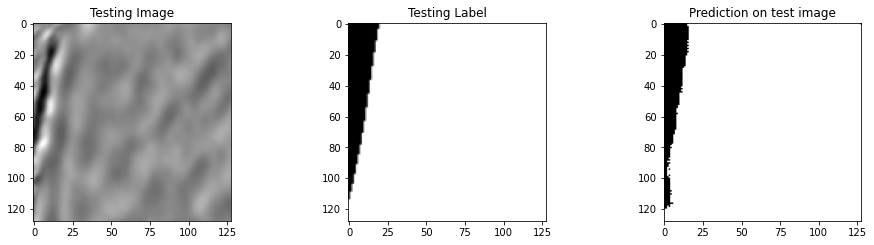

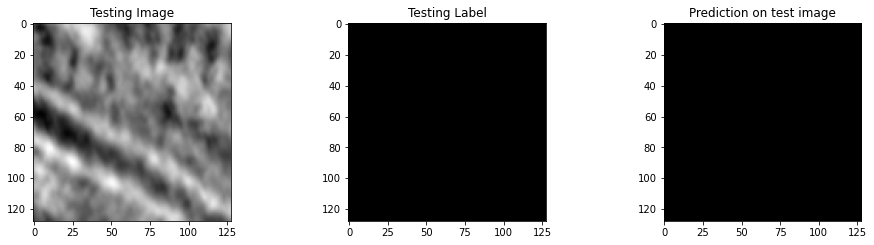

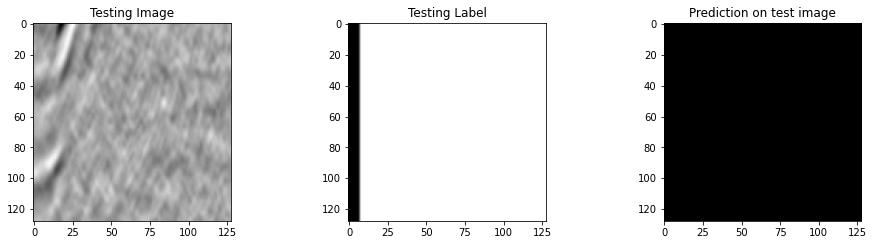

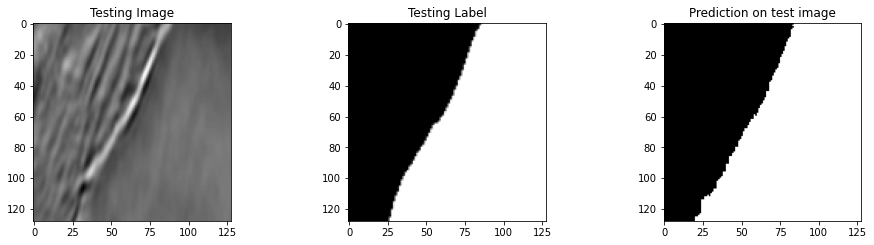

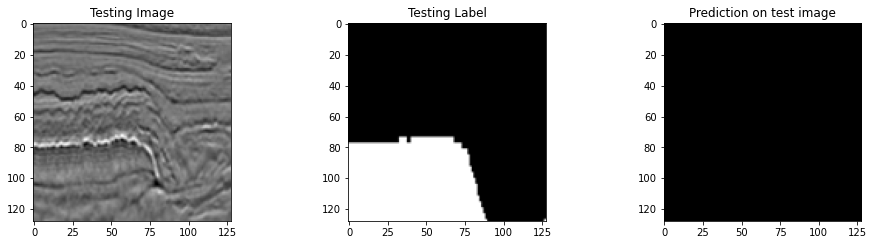

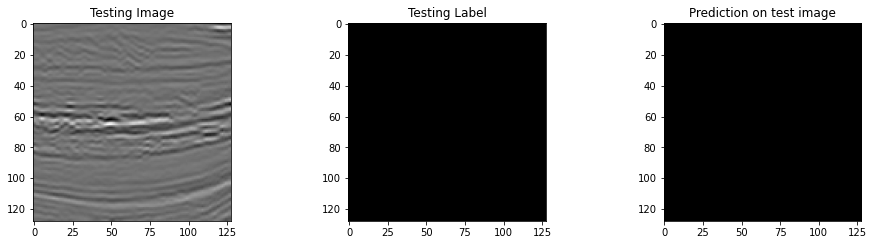

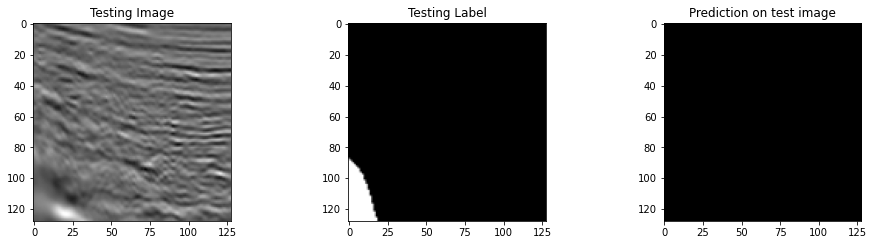

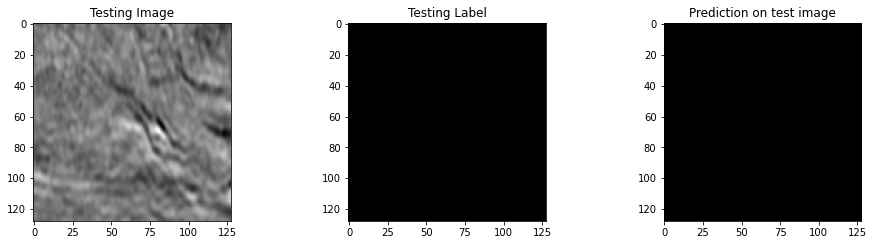

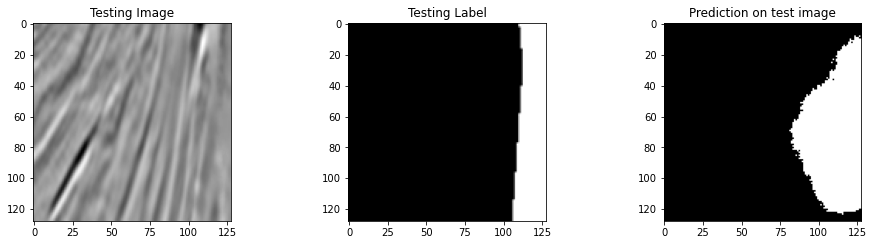

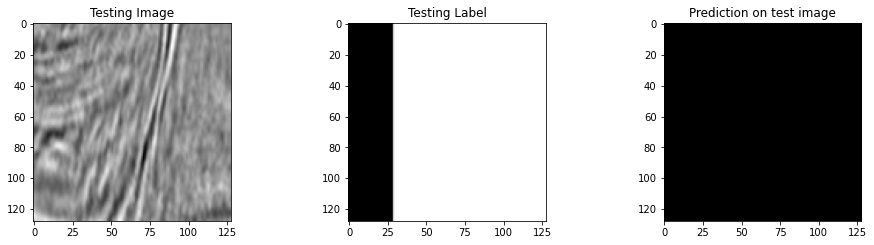

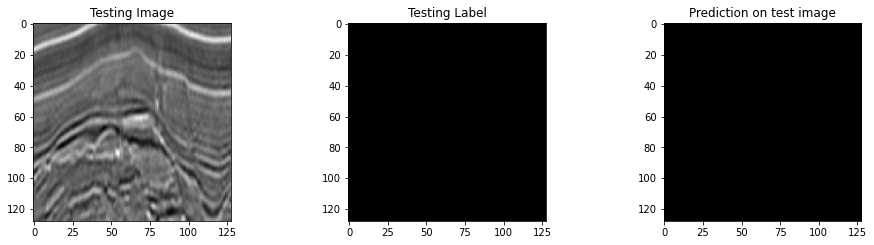

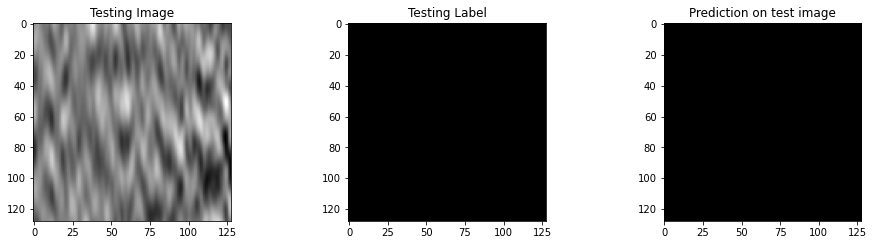

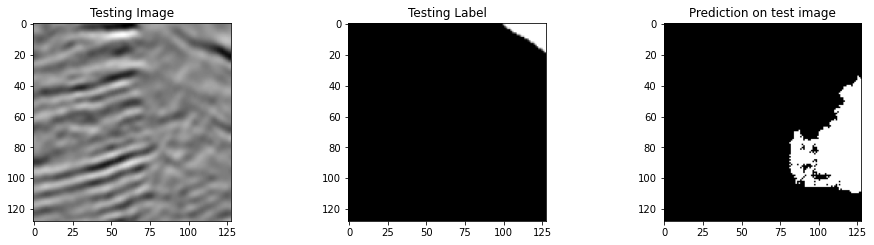

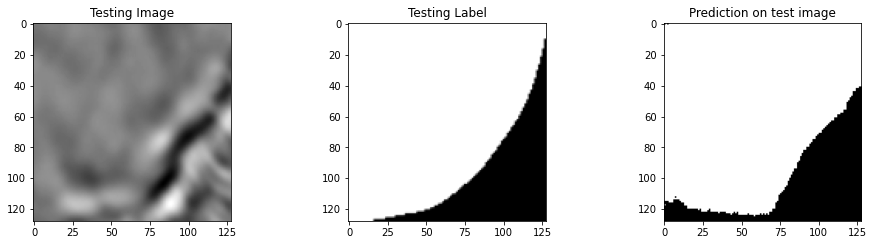

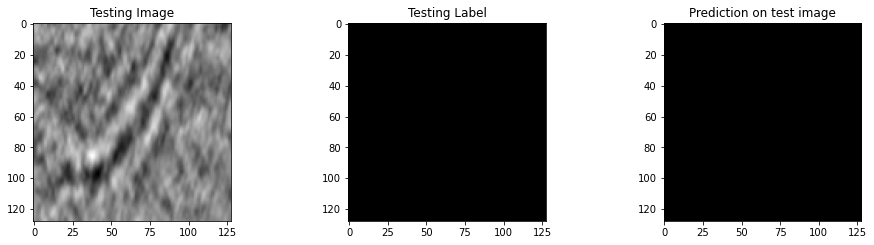

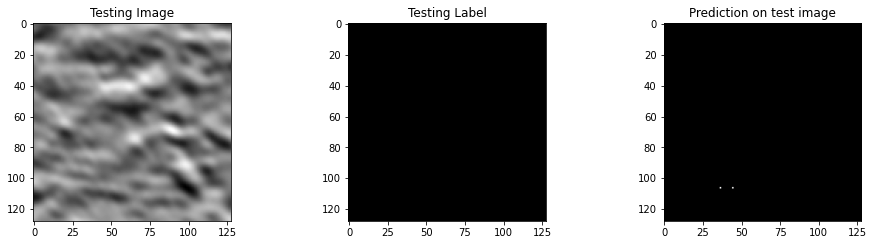

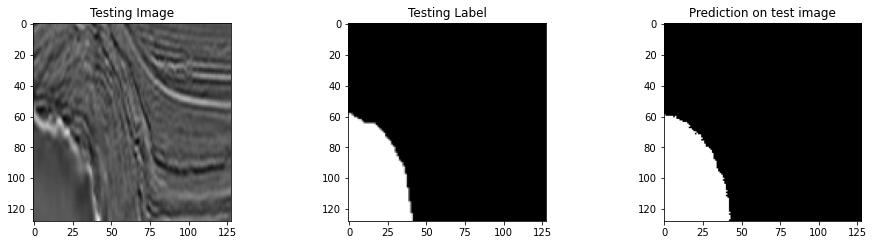

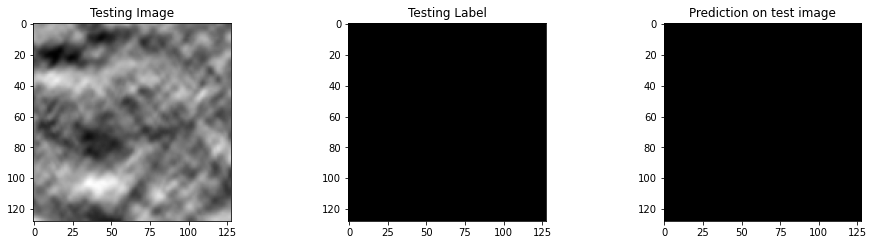

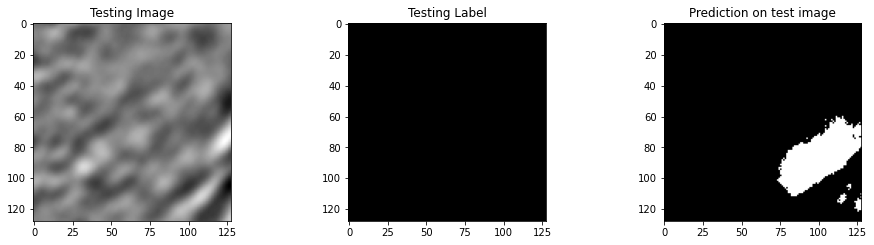

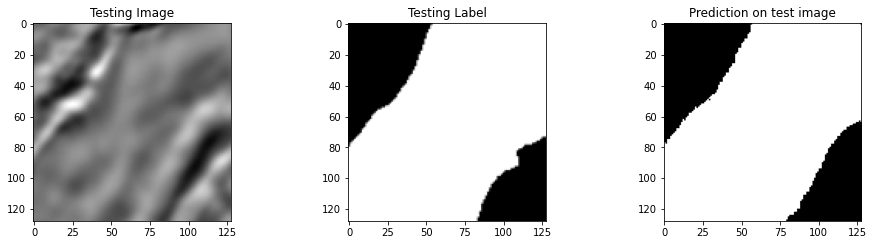

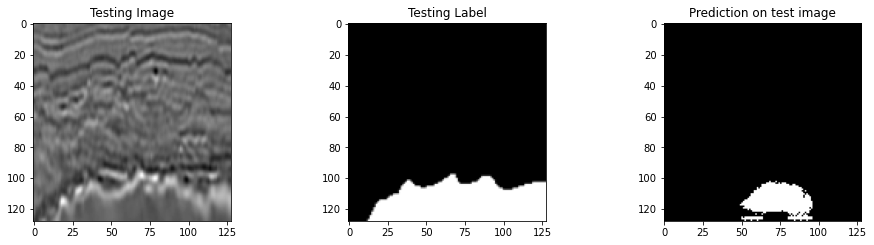

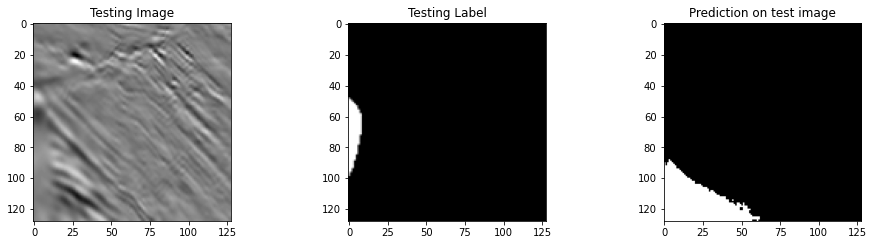

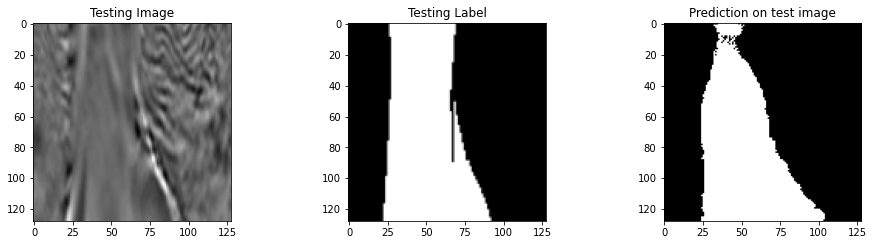

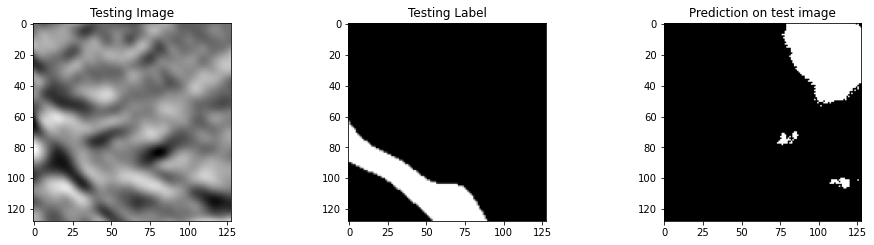

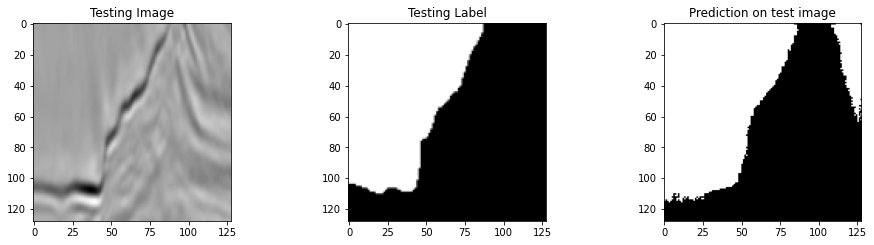

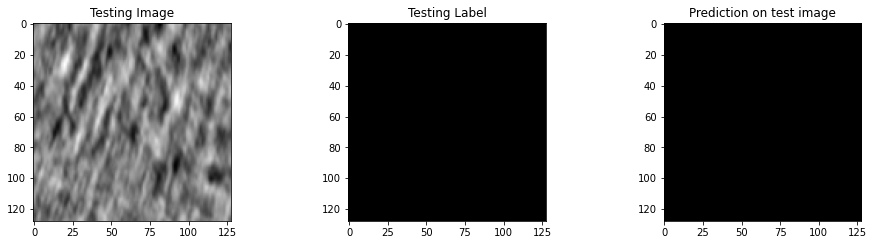

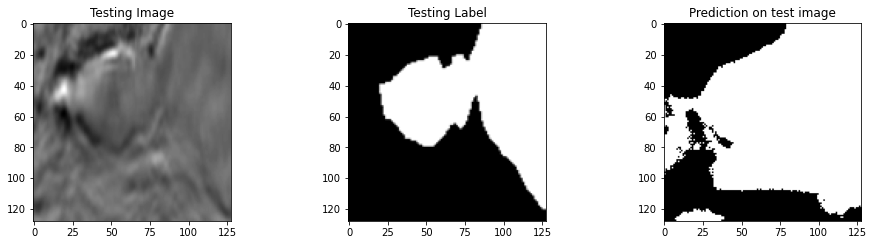

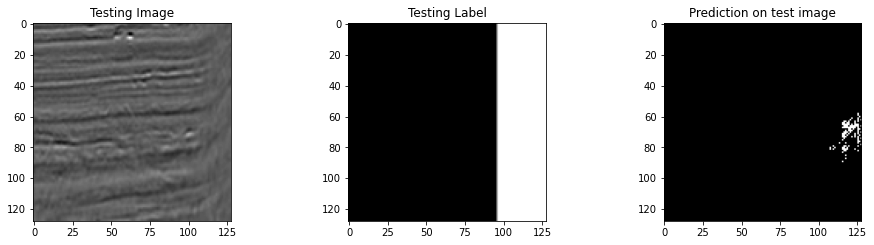

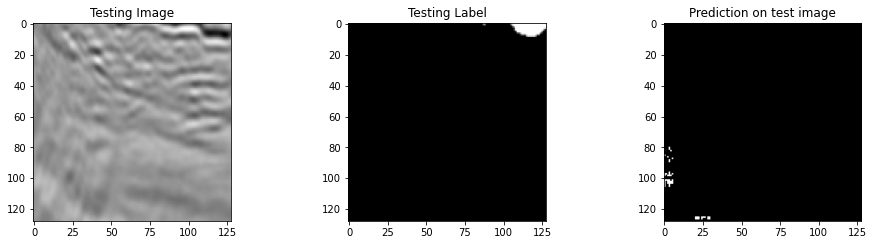

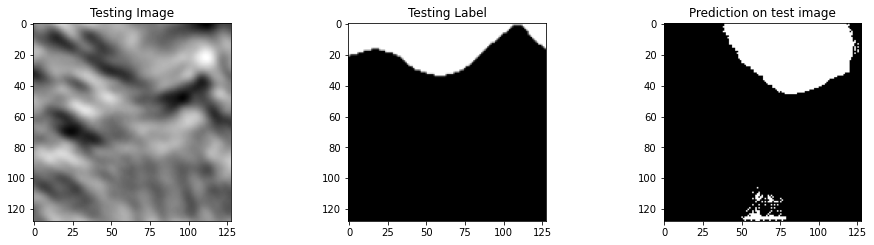

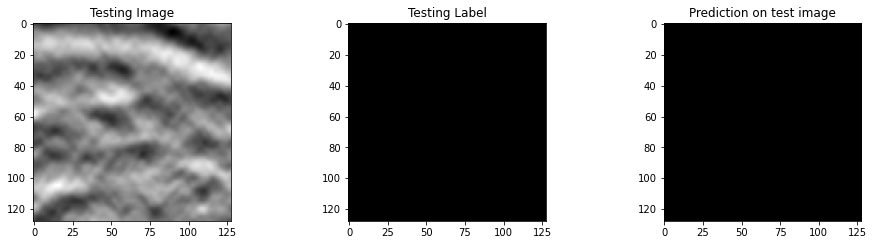

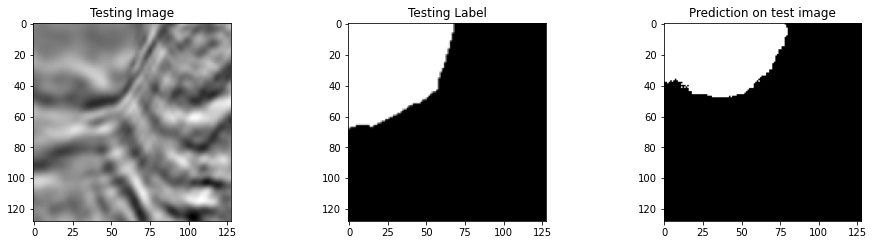

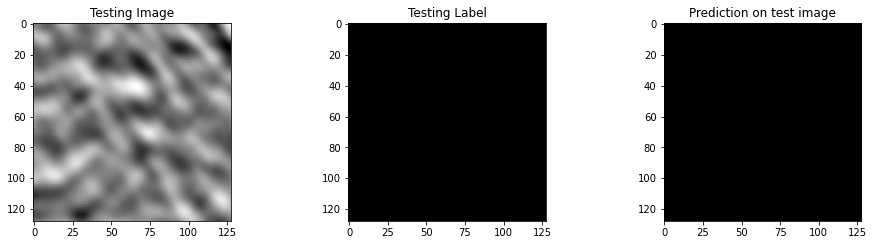

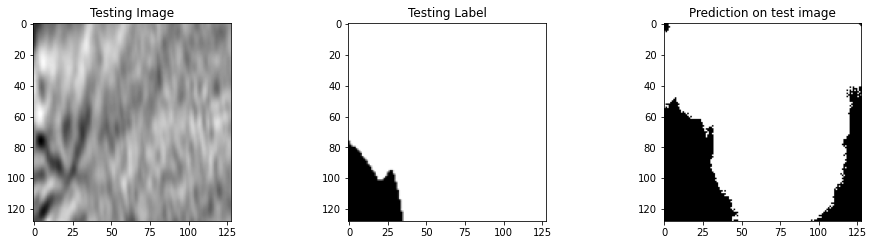

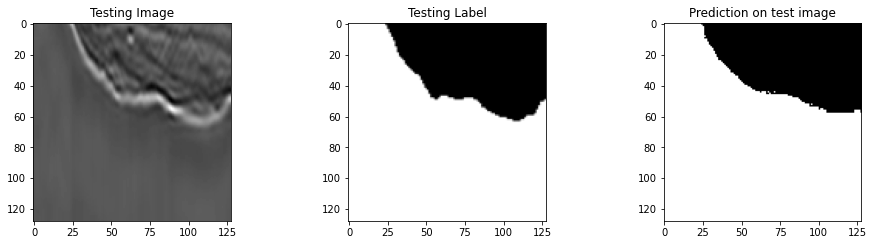

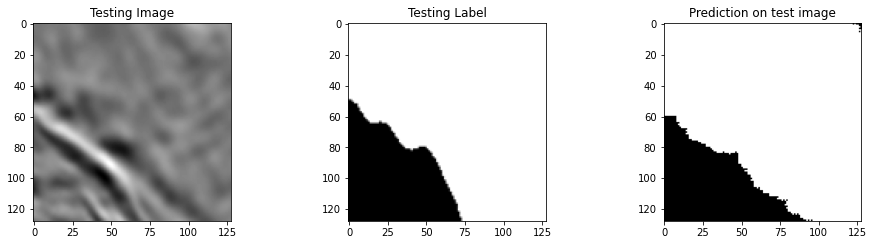

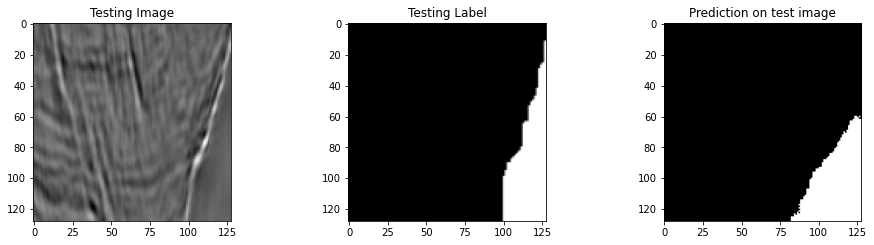

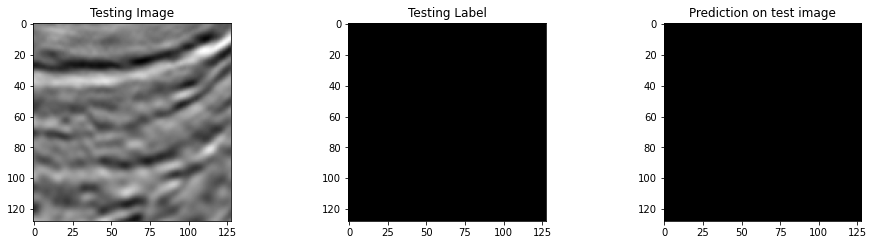

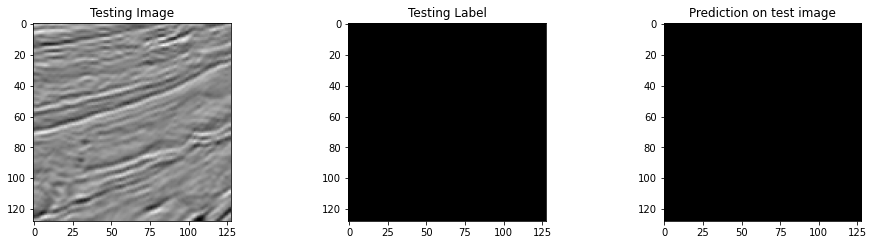

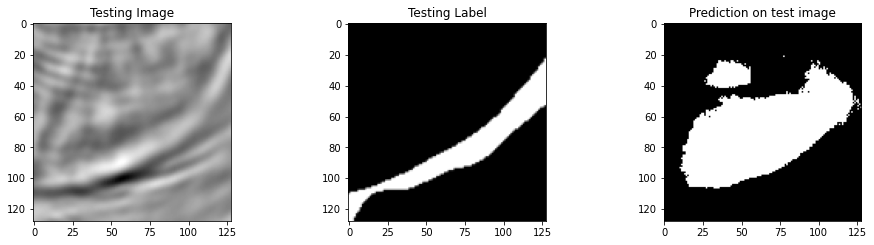

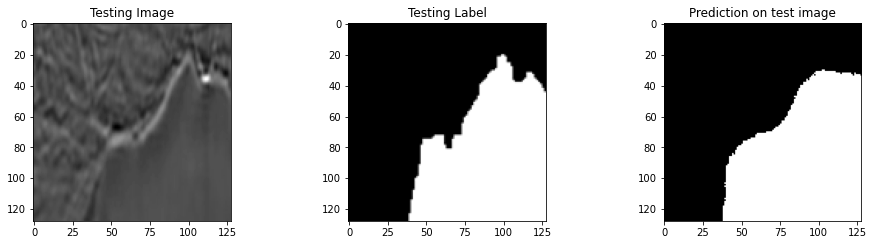

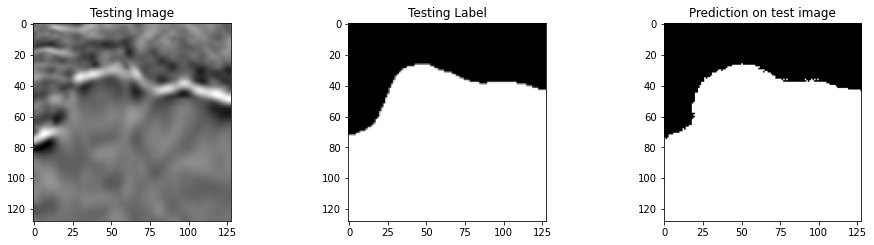

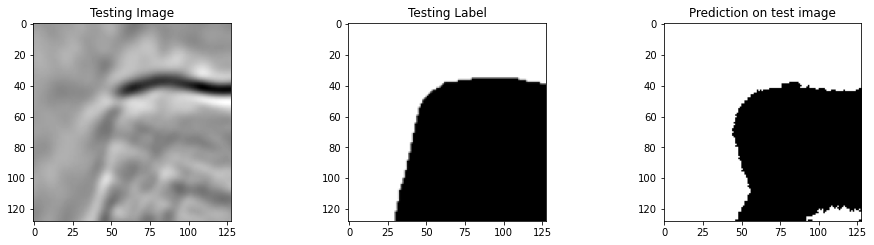

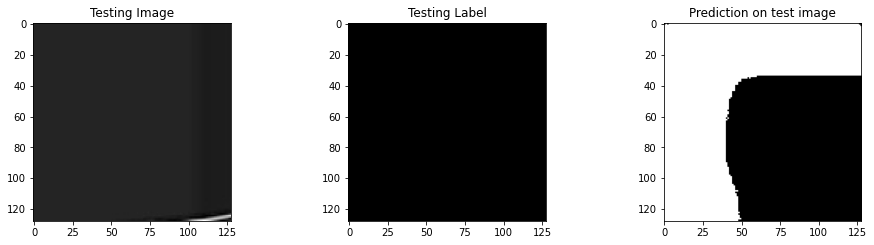

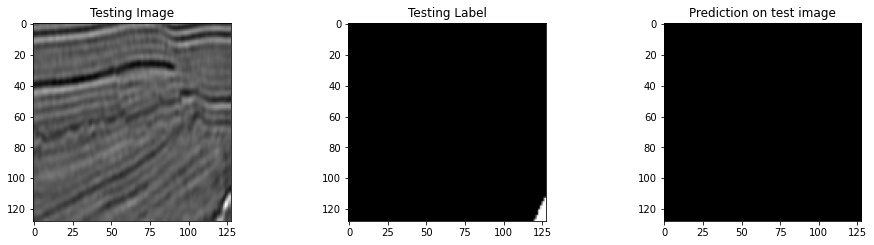

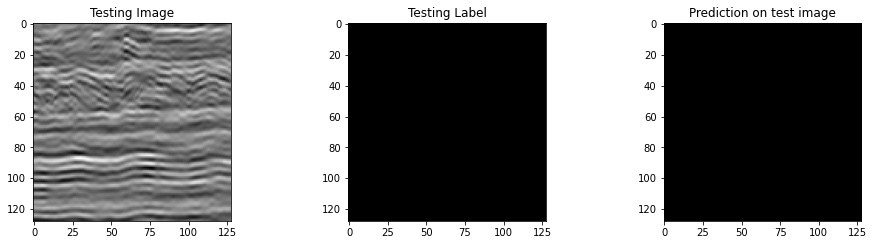

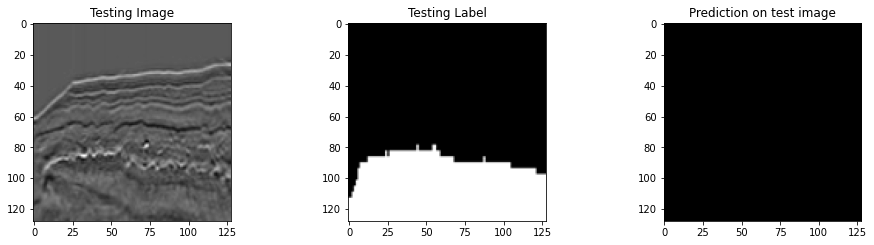

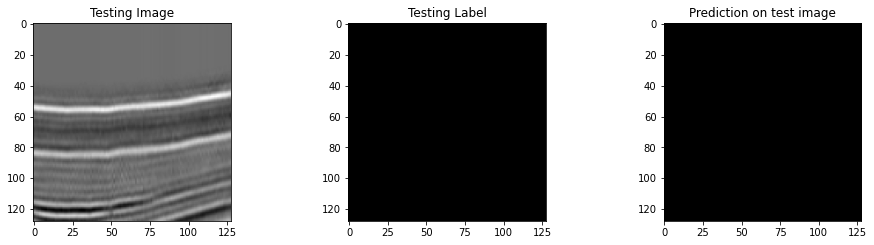

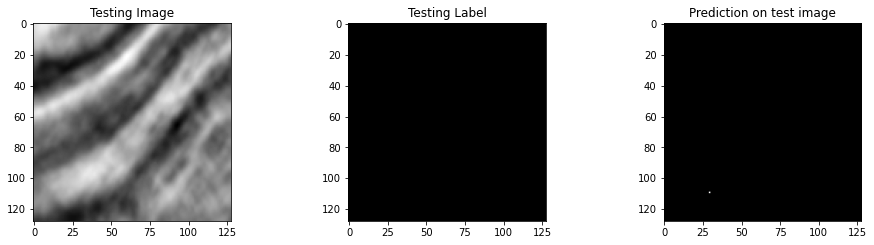

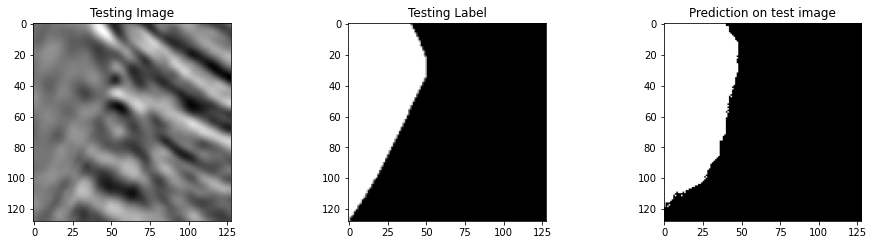

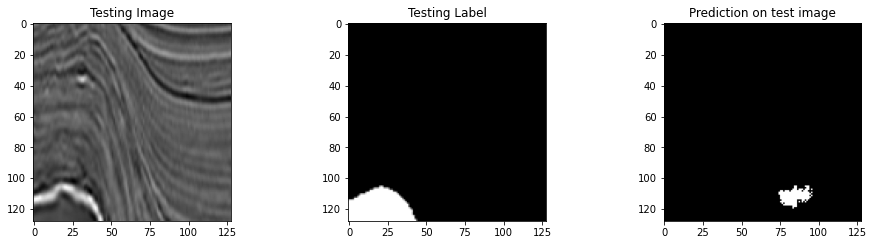

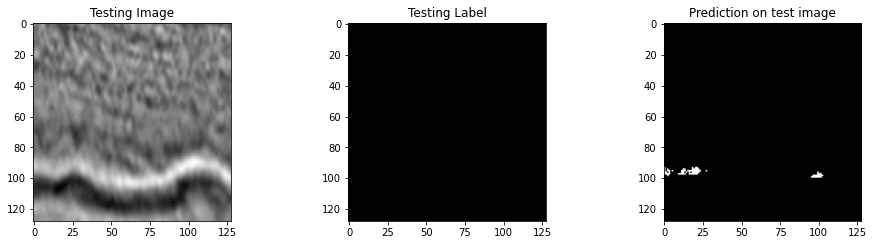

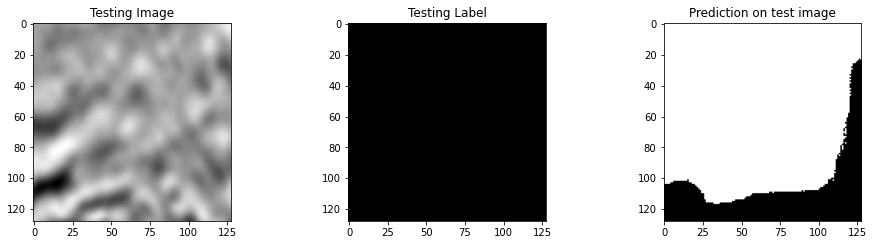

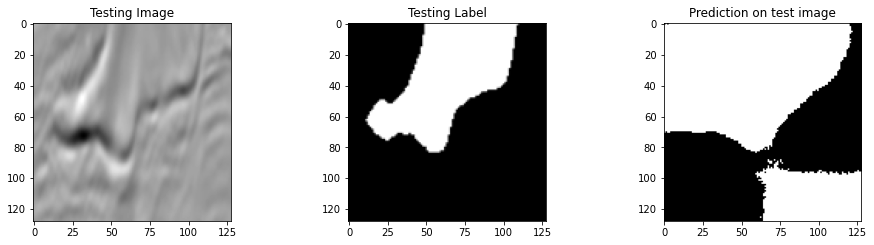

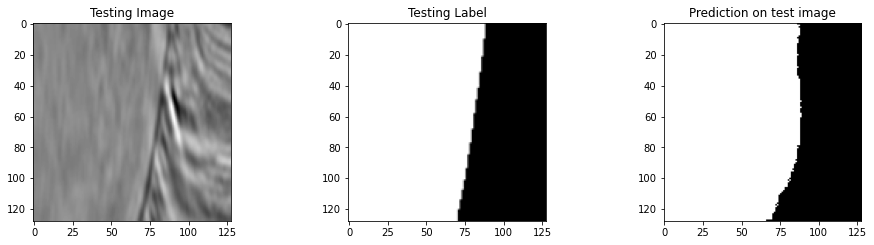

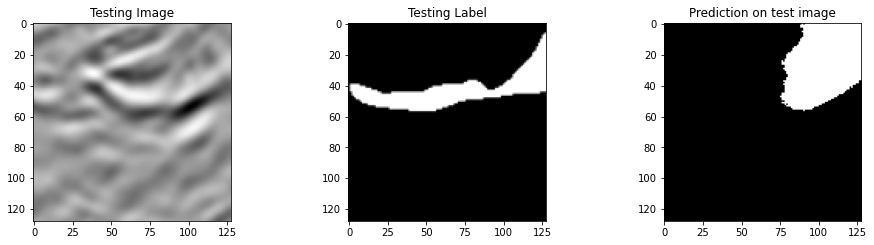

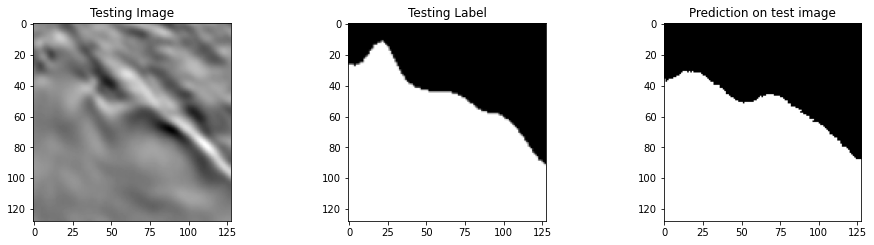

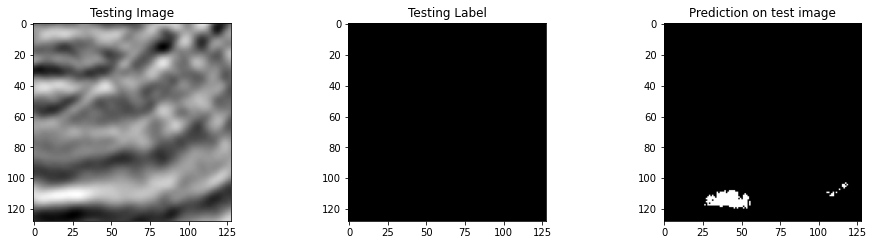

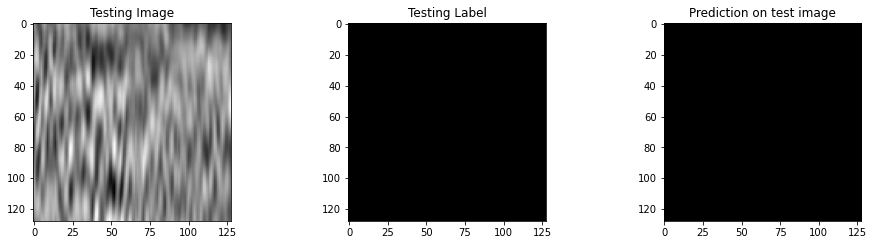

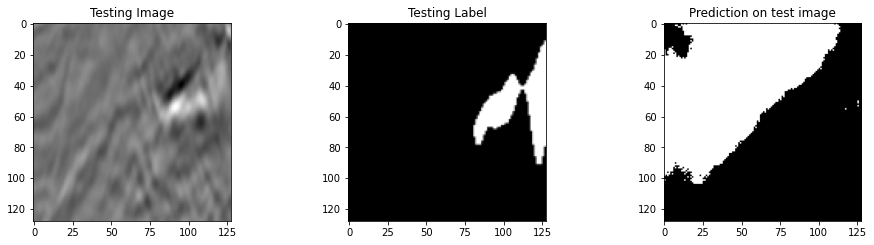

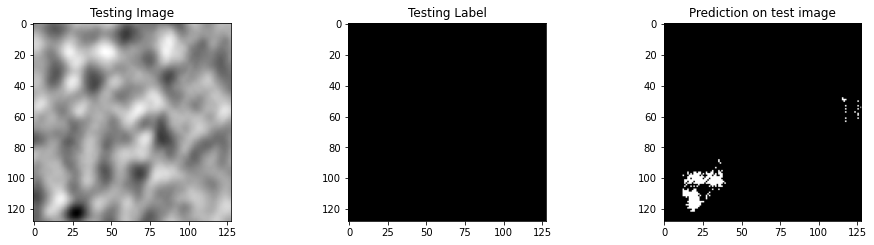

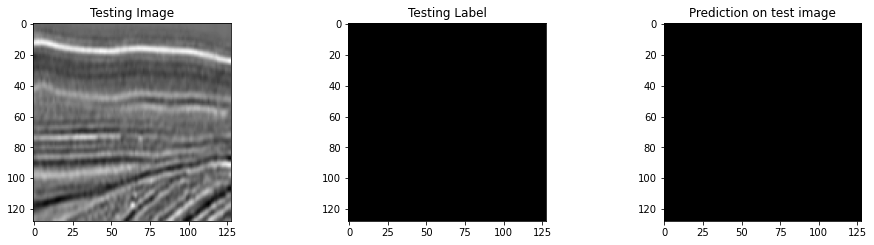

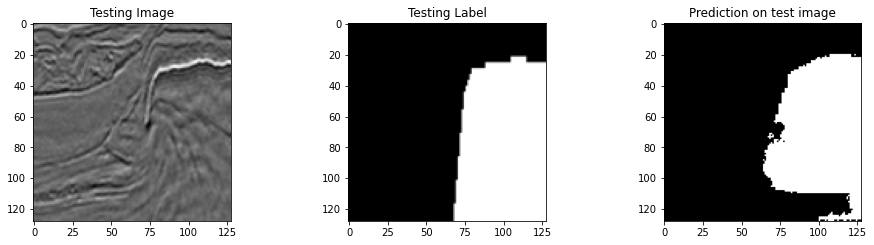

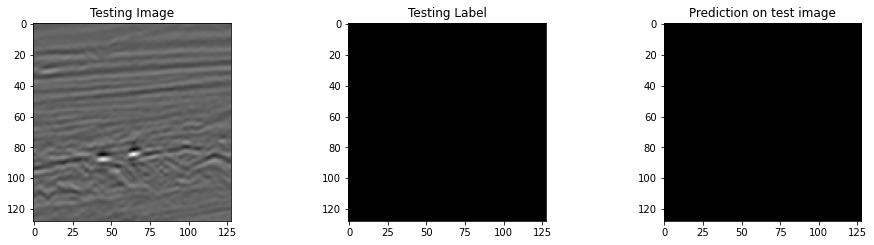

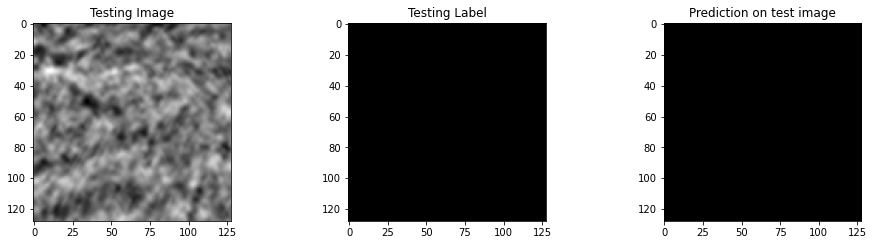

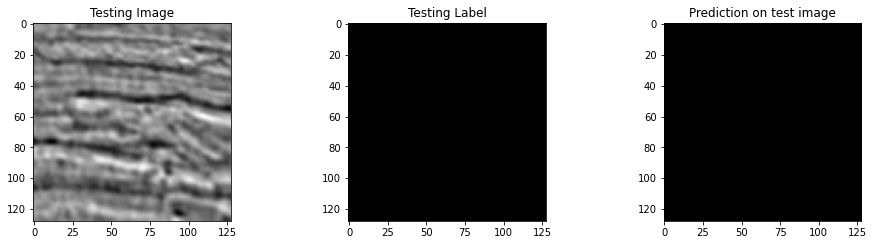

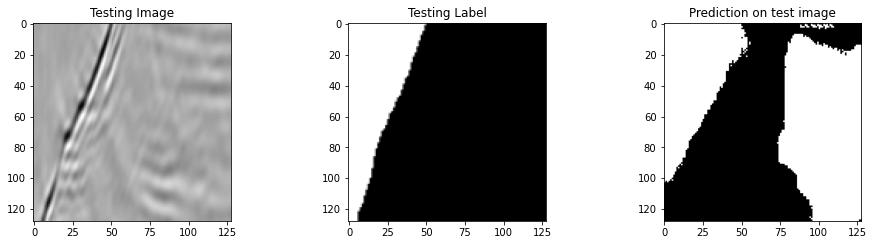

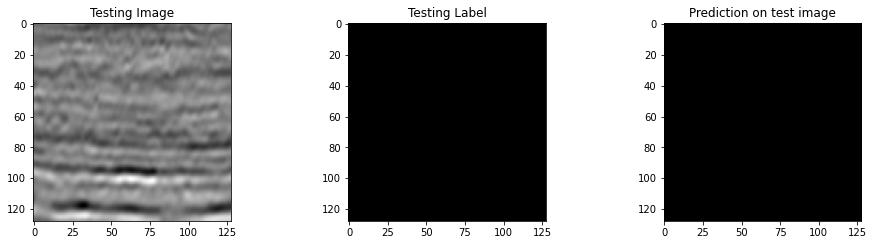

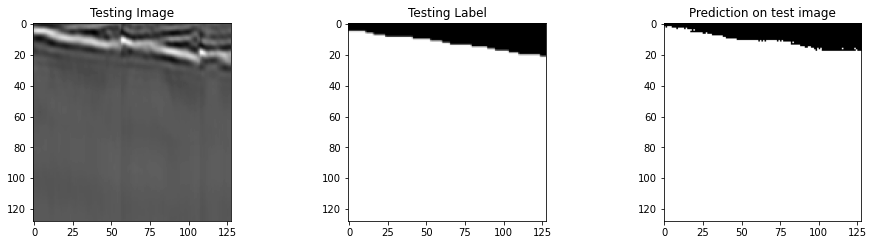

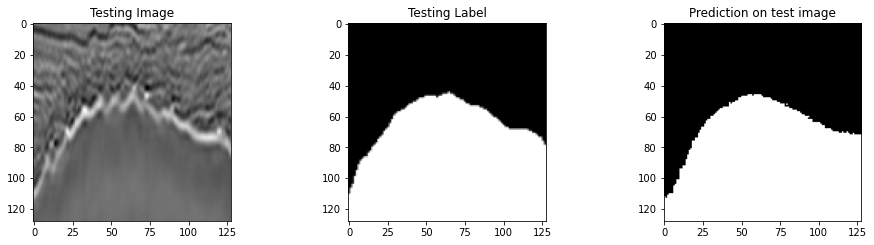

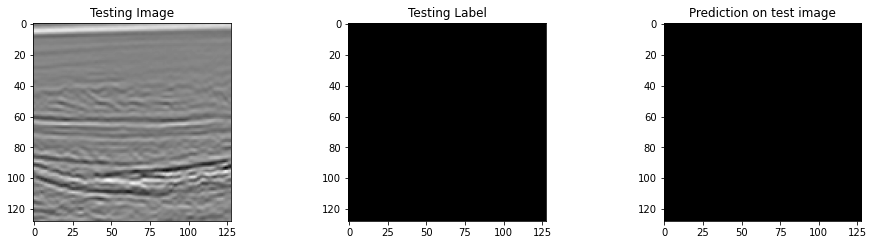

KeyboardInterrupt: 

In [33]:
# test_img_number = random.randint(0, len(X_test))
for i in range(len(X_test)):
    test_img_number = i
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(prediction, cmap='gray')
 
    plt.show()